In [1]:
! pip install 'cebra[dev,demos]' 

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: No such file or directory
/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: exec: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: cannot execute: No such file or directory


In [2]:
import sys
import os # my addtion

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.datasets
from cebra import CEBRA
import torch
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider

from sklearn import manifold
from sklearn.decomposition import PCA

from matplotlib.collections import LineCollection
import pandas as pd
import d_library as dl

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/lib/python3.11/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


This notebook will make an animation of the cebra embeddings: eventually will be converted to a function to animate the embeddings

In [8]:
#import CEBRA:
import cebra.datasets
from cebra import CEBRA
from cebra.datasets import get_datapath

In [5]:
iterations = 1000

In [6]:
# GET THIS FROM A LIBRARY SCRIPT LATER
def base_embed(input, temp=1, dimension=3, lr = 0.01, d=0.1):

    # build CEBRA time model
    model = CEBRA(model_architecture='offset1-model',
                         batch_size=512,
                         learning_rate=int(lr),
                         temperature=int(temp),
                         output_dimension = int(dimension),
                         max_iterations=iterations,
                         distance='euclidean',
                         delta=int(d),
                         conditional='delta',
                         device='cuda_if_available',
                         num_hidden_units=64,
                         verbose=True,
                         time_offsets=1)

    model.fit(input)
    embedding = model.transform(input)
    return model, embedding

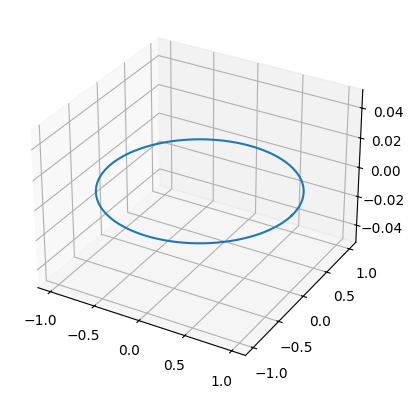

(100, 3)

In [7]:
%matplotlib inline
circle = dl.make_circle()
dl.plot_circle(circle[:,0], circle[:,1])
circle.shape

In [6]:
xyz = dl.make_lorenz()

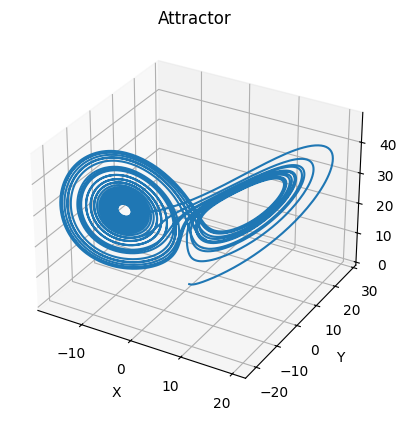

In [7]:
dl.plot_lorenz(xyz)

New Data to understand their Fig1b.

In [8]:
# reshape the lorenz object for use with cebra
lorenz_obj = xyz.reshape(10000,3)
lorenz_obj.shape

(10000, 3)

In [11]:
xyz.shape

(3, 10000)

In [12]:
l = xyz.reshape(-1,3)

In [13]:
l.shape

(10000, 3)

In [10]:
# ideal model for circle and lorenz inputs
ideal_model, ideal_embedding = base_embed(input=circle, temp=1, dimension=3, lr = 0.1, d=0.1) 
ideal_model_l, ideal_embedding_l = base_embed(input=lorenz_obj, temp=1,dimension=3, lr=0.01, d=1)

pos:  0.0000 neg:  6.2197 total:  6.2198 temperature:  1.0000: 100%|██████████| 2000/2000 [00:22<00:00, 89.70it/s]
pos:  0.0020 neg:  5.6261 total:  5.6280 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.30it/s]


<Axes3D: title={'center': 'Lorenz Attractor'}>

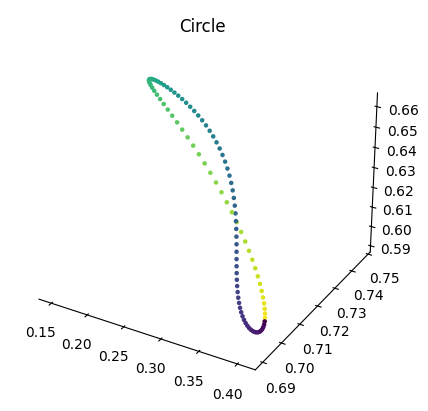

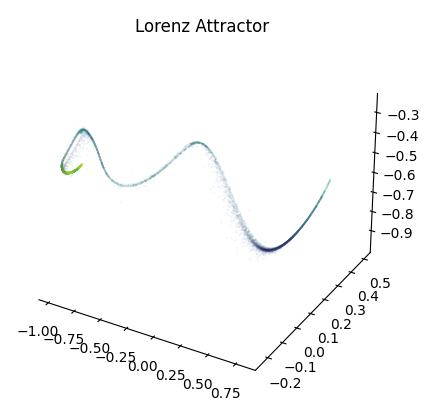

In [11]:
cebra.plot_embedding(ideal_embedding, embedding_labels='time', markersize=5, alpha=1, title='Circle')
cebra.plot_embedding(ideal_embedding_l, embedding_labels='time', markersize=0.001, alpha=1, title='Lorenz Attractor')

Ok, now that we have some embeddigns and useful inputs to animate, let's make a function to animate them.

In [10]:
def animate_attractor(attractor):

    # insert statement to make sure the input is the correct shape

    model_pl2, embed_pl2 = base_embed(attractor, dimension=2)
    model_pl3, embed_pl3 = base_embed(attractor, dimension=3)

    # define the grid and axes
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(2, 2, figure=fig) 
    ax1 = plt.subplot(gs[0, :], projection='3d')
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1], projection='3d')

    def update(frame):
            ax1.clear()
            ax2.clear()
            ax3.clear()

            attractor_p = attractor[:, :frame]

            ax1.plot(attractor_p[0], attractor_p[1], attractor_p[2], alpha=1)
            ax1.set_title('Timestep {}'.format(frame))

            cebra.plot_embedding(embedding=embed_pl2[0:frame + 1000, :], embedding_labels= 'time', title='2D Embedding', markersize=5, ax=ax2)
            cebra.plot_embedding(embedding=embed_pl3[0:frame, :], embedding_labels='time', markersize=5, title='3D Embedding', ax=ax3)

    anima = FuncAnimation(fig, update, frames=range(0, attractor.shape[1], 100), blit=False, interval=200, repeat=False)
    plt.show()
    anima.save("anima.gif", writer='pillow')

In [15]:
lorenz_obj.shape

(10000, 3)

pos:  0.0002 neg:  6.1463 total:  6.1465 temperature:  1.0000: 100%|██████████| 2000/2000 [00:23<00:00, 85.76it/s]
pos:  0.0031 neg:  6.0315 total:  6.0346 temperature:  1.0000: 100%|██████████| 2000/2000 [00:22<00:00, 88.44it/s]


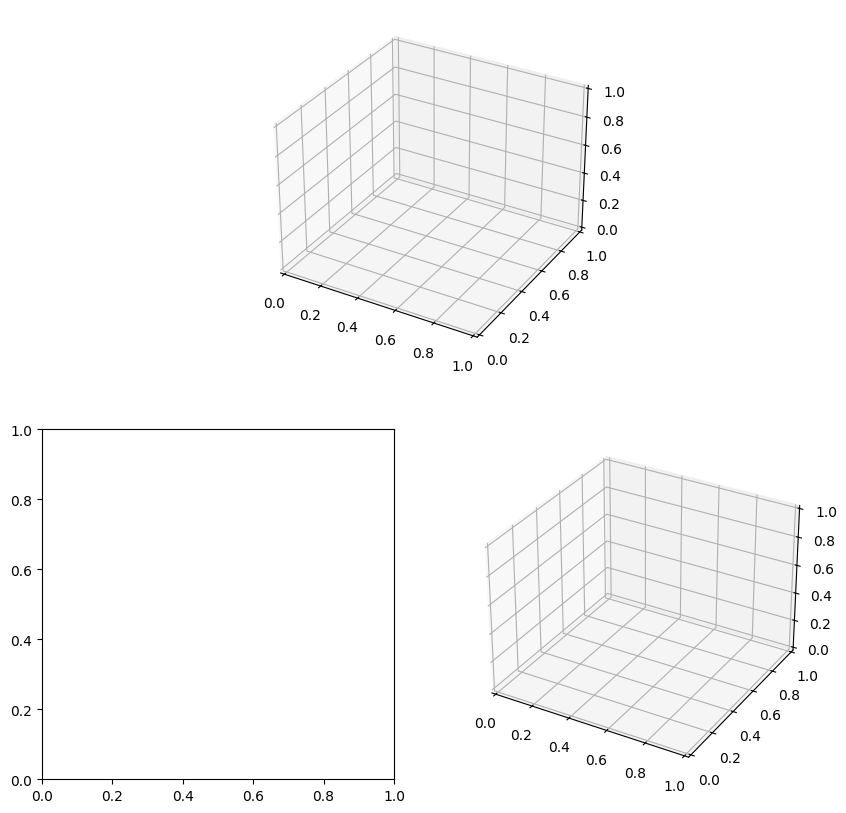

In [16]:
animate_attractor(xyz)

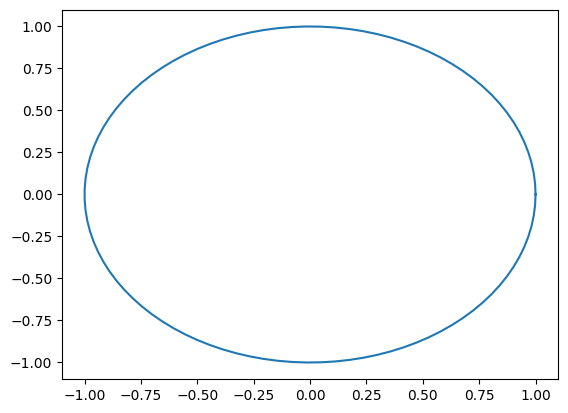

In [17]:
# simpler test version
plt.plot(circle[:,0], circle[:,1])

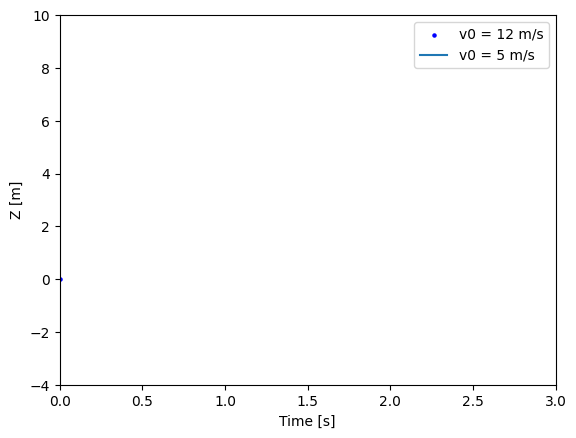

In [26]:
%matplotlib inline
is_manual = False # True if user has taken control of the animation

# create figure and axis
fig, ax = plt.subplots()

# define the 2 functions of time
t = np.linspace(0, 3, 40)
g = -9.81
v0 = 12
z = g * t**2 / 2 + v0 * t

v02 = 5
z2 = g * t**2 / 2 + v02 * t

# define the axis and label it
scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()

# update function
def update(frame):
    # for each frame, update the data stored on each artist.
    x = t[:frame]
    y = z[:frame]
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    # update the line plot:
    line2.set_xdata(t[:frame])
    line2.set_ydata(z2[:frame])
    return (scat, line2)



ani = FuncAnimation(fig=fig, func=update, frames=40, interval=300)
plt.show()
ani.save('test_ani.gif', writer='pillow')